<figure>
  <IMG SRC="Logo.png"  WIDTH=150 ALIGN="right">
</figure>

## Projections of mean sea level and tides<br>
### Paper in Journal of Coastal and Hydraulic Structures
<b>Prepared by: H.G. Voortman</b>


<figure>
    <IMG SRC="https://www.python.org/static/community_logos/python-powered-w-200x80.png"  WIDTH=100 ALIGN="right">
</figure>

#### Description
- Analyses described in section 5 of the paper

#### Packages

In [2]:
# General packages
import copy as cp
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sq
import numpy as np
#import sigfig as sf
import scipy.stats as stat

import hvec_stat.general_fit as gf
import hvec_stat.plotting as stplot
import hvec_stat.goodness_of_fit as gof
import hvec_stat.support as sup
import hvec_stat.statistical_tests as sttests
from hvec_sealevel_scenarios import regressionModels as mdl
import utils as prj

from constants import RESULTS, PICTURES

In [3]:
# Settings
plt.rcParams['axes.grid'] = True
figsize = (20, 18)

In [4]:
tiny = 1e-12

In [5]:
bnd_lo = [-np.inf, -np.inf,          0,       0, -np.inf, -np.inf, -np.inf, -np.inf]
bnd_up = [ np.inf,  np.inf,     np.inf,  np.inf,  np.inf,  np.inf,  np.inf,  np.inf]

In [6]:
# Set confidence level of interval
conf = 0.9
k = stat.norm.ppf(1 - (1 - conf) / 2)
k.round(3)

1.645

#### Connect databases and import data

##### Processed data Rijkswaterstaat

In [7]:
df = prj.read_data_rws(constit_set = 'Ftested3')

In [8]:
df = df.loc[df['year'] >= 1945]

##### Data IPCC

In [9]:
ipcc = prj.read_data_ipcc()
ipcc = prj.process_ipcc(ipcc, k)

c:\Users\Hessel Voortman\OneDrive - Hessel Voortman EC BV\20 Werk\2022_014 - papers sea level and tide\JCHS_sea_level_North_Sea\utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['90%_band'] = df['90%_high'] - df['median']
c:\Users\Hessel Voortman\OneDrive - Hessel Voortman EC BV\20 Werk\2022_014 - papers sea level and tide\JCHS_sea_level_North_Sea\utils.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sigma'] = (df['90%_band'] / k).round(2)
c:\Users\Hessel Voortman\OneDrive - Hessel Vo

#### Calibrate per model

In [10]:
param = pd.DataFrame(columns = [
    'name',
    'var',
    'model',
    'intercept',
    'slope',
    'sigma_slope',
    '90%_band_slope',
    'acceleration',
    'jerk',
    'A_885',
    'A_1861',
    'Rsqadj'], dtype = float)

In [11]:
vars = ['z0']

In [12]:
names = df['naam'].unique()

In [13]:
tprescr_lo = 1970
tprescr_up = 2005

In [14]:
df

,naam,level_1,z0,zmean,count,M2,S2,Rsq_adj,MHWS,MLWS,...,P1,N2,M6,MU2,L2,2MS6,MS4,NU2,SA,M2+S2
931,Delfzijl,0,0.011015,0.029767,2920.0,1.244025,0.287043,0.866229,1.542083,-1.520053,...,NaN,0.196611,0.072752,NaN,NaN,NaN,NaN,NaN,NaN,1.531068
932,Delfzijl,0,-0.009354,0.003979,2920.0,1.235225,0.302414,0.853800,1.528285,-1.546993,...,NaN,0.188070,0.068526,NaN,NaN,NaN,NaN,NaN,NaN,1.537639
933,Delfzijl,0,-0.093909,-0.105527,2920.0,1.214612,0.307362,0.804662,1.428066,-1.615883,...,NaN,0.164572,0.063057,NaN,NaN,NaN,NaN,NaN,NaN,1.521975
934,Delfzijl,0,-0.011364,-0.002097,2928.0,1.199373,0.303906,0.834635,1.491915,-1.514643,...,NaN,0.184133,0.064774,NaN,NaN,NaN,NaN,NaN,NaN,1.503279
935,Delfzijl,0,-0.025741,0.020603,2920.0,1.197049,0.307011,0.803071,1.478320,-1.529801,...,NaN,0.170231,0.065582,NaN,NaN,NaN,NaN,NaN,NaN,1.504060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6866,Vlissingen,0,0.029327,0.046079,8760.0,1.769901,0.464225,0.933409,2.263452,-2.204799,...,NaN,0.280464,0.105112,NaN,NaN,NaN,NaN,NaN,NaN,2.234126
6867,Vlissingen,0,-0.005709,0.000808,8760.0,1.781764,0.458311,0.933475,2.234366,-2.245784,...,NaN,0.263412,0.102119,NaN,NaN,NaN,NaN,NaN,NaN,2.240075
6868,Vlissingen,0,0.041688,0.050753,8760.0,1.742223,0.460194,0.934587,2.244106,-2.160730,...,NaN,0.283159,0.103165,NaN,NaN,NaN,NaN,NaN,NaN,2.202418
6869,Vlissingen,0,0.041021,0.058649,8784.0,1.758629,0.459898,0.927820,2.259548,-2.177506,...,NaN,0.285313,0.103004,NaN,NaN,NaN,NaN,NaN,NaN,2.218527


In [19]:
data = df[df['naam'] == 'Vlissingen']
vr = 'z0'

In [20]:
 gf.fit_with_uncert(
            mdl.fullModel,
            data['year'],
            data[vr],
            bounds = (
                bnd_lo + [tprescr_lo - data['year'].mean()],
                bnd_up + [tprescr_up - data['year'].mean()]), method = 'Bence')


{'p': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'k': 11,
 'sigma': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'E_x': nan,
 's_resid': nan,
 'Neff': nan,
 'Rsqadj': nan,
 'SS_resid': nan,
 'Method': 'Bence'}

In [ ]:
data

,naam,level_1,z0,zmean,count,M2,S2,Rsq_adj,MHWS,MLWS,...,P1,N2,M6,MU2,L2,2MS6,MS4,NU2,SA,M2+S2


In [ ]:
# Full model
tmp = pd.DataFrame()

namestore = []
varstore = []
modelstore = []
intercept = []
slope = []
acceleration = []
jerk = []
A_885 = []
A_1861 = []
t0 = []
Rsqadj = []

for vr in vars:
    for nm in names:
        """
        if nm == 'Delfzijl':
            if vr != 'z0':
                continue
        """
        data = df[df['naam'] == nm]
        res = gf.fit_with_uncert(
            mdl.fullModel,
            data['year'],
            data[vr],
            bounds = (
                bnd_lo + [tprescr_lo - data['year'].mean()],
                bnd_up + [tprescr_up - data['year'].mean()]), method = 'Bence')

        p = res['p']

        namestore.append(nm)
        varstore.append(vr)
        modelstore.append('Full')
        intercept.append(p[0])
        slope.append(p[1])
        acceleration.append(p[2])
        jerk.append(p[3])
        A_885.append(np.sqrt(p[4]**2 + p[5]**2))
        A_1861.append(np.sqrt(p[6]**2 + p[7]**2))
        t0.append(p[8] + data['year'].mean())
        Rsqadj.append(res['Rsqadj'])
        

tmp['name'] = namestore
tmp['var'] = varstore
tmp['model'] = modelstore
tmp['intercept'] = intercept
tmp['slope'] = slope
tmp['acceleration'] = acceleration
tmp['jerk'] = jerk
tmp['A_885'] = A_885
tmp['A_1861'] = A_1861
tmp['t0'] = t0
tmp['Rsqadj'] = Rsqadj

param = pd.concat([param, tmp])

In [ ]:
res

{'p': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'k': 11,
 'sigma': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'E_x': nan,
 's_resid': nan,
 'Neff': nan,
 'Rsqadj': nan,
 'SS_resid': nan,
 'Method': 'Bence'}

In [ ]:
# Reduced model
tmp = pd.DataFrame()

namestore = []
varstore = []
modelstore = []
intercept = []
slope = []
band = []
acceleration = []
jerk = []
A_885 = []
A_1861 = []
t0 = []
Rsqadj = []

for vr in vars:
    for nm in names:
        data = df[df['naam'] == nm]
        res = gf.fit_with_uncert(
            mdl.reducedModel,
            data['year'],
            data[vr])

        p = res['p']
        sigma = res['sigma']

        namestore.append(nm)
        varstore.append(vr)
        modelstore.append('Reduced')
        intercept.append(p[0])
        slope.append(p[1])
        band.append(sigma[1] * k)
        A_885.append(np.sqrt(p[2]**2 + p[3]**2))
        A_1861.append(np.sqrt(p[4]**2 + p[5]**2))
        Rsqadj.append(res['Rsqadj'])
        

tmp['name'] = namestore
tmp['var'] = varstore
tmp['model'] = modelstore
tmp['intercept'] = intercept
tmp['slope'] = slope
tmp['90%_band_slope'] = band
tmp['sigma_slope'] = band / k
tmp['A_885'] = A_885
tmp['A_1861'] = A_1861
tmp['Rsqadj'] = Rsqadj

param = pd.concat([param, tmp])

In [ ]:
# Set units (length mm and time centuries) for publication table
param['intercept'] = (1000 * param['intercept']).round()
param['slope'] = (1e5 * param['slope']).round()
param['90%_band_slope'] = (1e5 * param['90%_band_slope']).round()
param['sigma_slope'] = (1e5 * param['sigma_slope']).round()
param['acceleration'] = (1e7 * param['acceleration']).round()
param['jerk'] = (1e9 * param['jerk']).round()
param['A_885'] = (1e3 * param['A_885']).round()
param['A_1861'] = (1e3 * param['A_1861']).round()
param['Rsqadj'] = (1e2 * param['Rsqadj']).round()
#param['p-value'] = (1e2 * param['p-value']).apply(lambda x: sf.round(x, 2))
param['t0'] = param['t0'].round()

In [ ]:
param.sort_values(by = ['model', 'name'], inplace = True)

In [ ]:
param

,name,var,model,intercept,slope,sigma_slope,90%_band_slope,acceleration,jerk,A_885,A_1861,Rsqadj,t0
0,Delfzijl,z0,Full,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Den Helder,z0,Full,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Harlingen,z0,Full,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hoek van Holland,z0,Full,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IJmuiden,z0,Full,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Vlissingen,z0,Full,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Delfzijl,z0,Reduced,42.0,242.0,17.0,28.0,NaN,NaN,8.0,19.0,75.0,NaN
1,Den Helder,z0,Reduced,-51.0,164.0,17.0,28.0,NaN,NaN,3.0,19.0,60.0,NaN
2,Harlingen,z0,Reduced,1.0,185.0,18.0,30.0,NaN,NaN,7.0,15.0,57.0,NaN
3,Hoek van Holland,z0,Reduced,22.0,217.0,16.0,27.0,NaN,NaN,4.0,13.0,75.0,NaN


In [ ]:
param[(param['var'] == 'z0') & (param['model'] == 'Model 3')].drop(['var', 'intercept', 'model', 'acceleration', 'jerk', 't0'], axis = 1).to_excel(f'{RESULTS}/fitted_models_z0.xlsx', index = False)

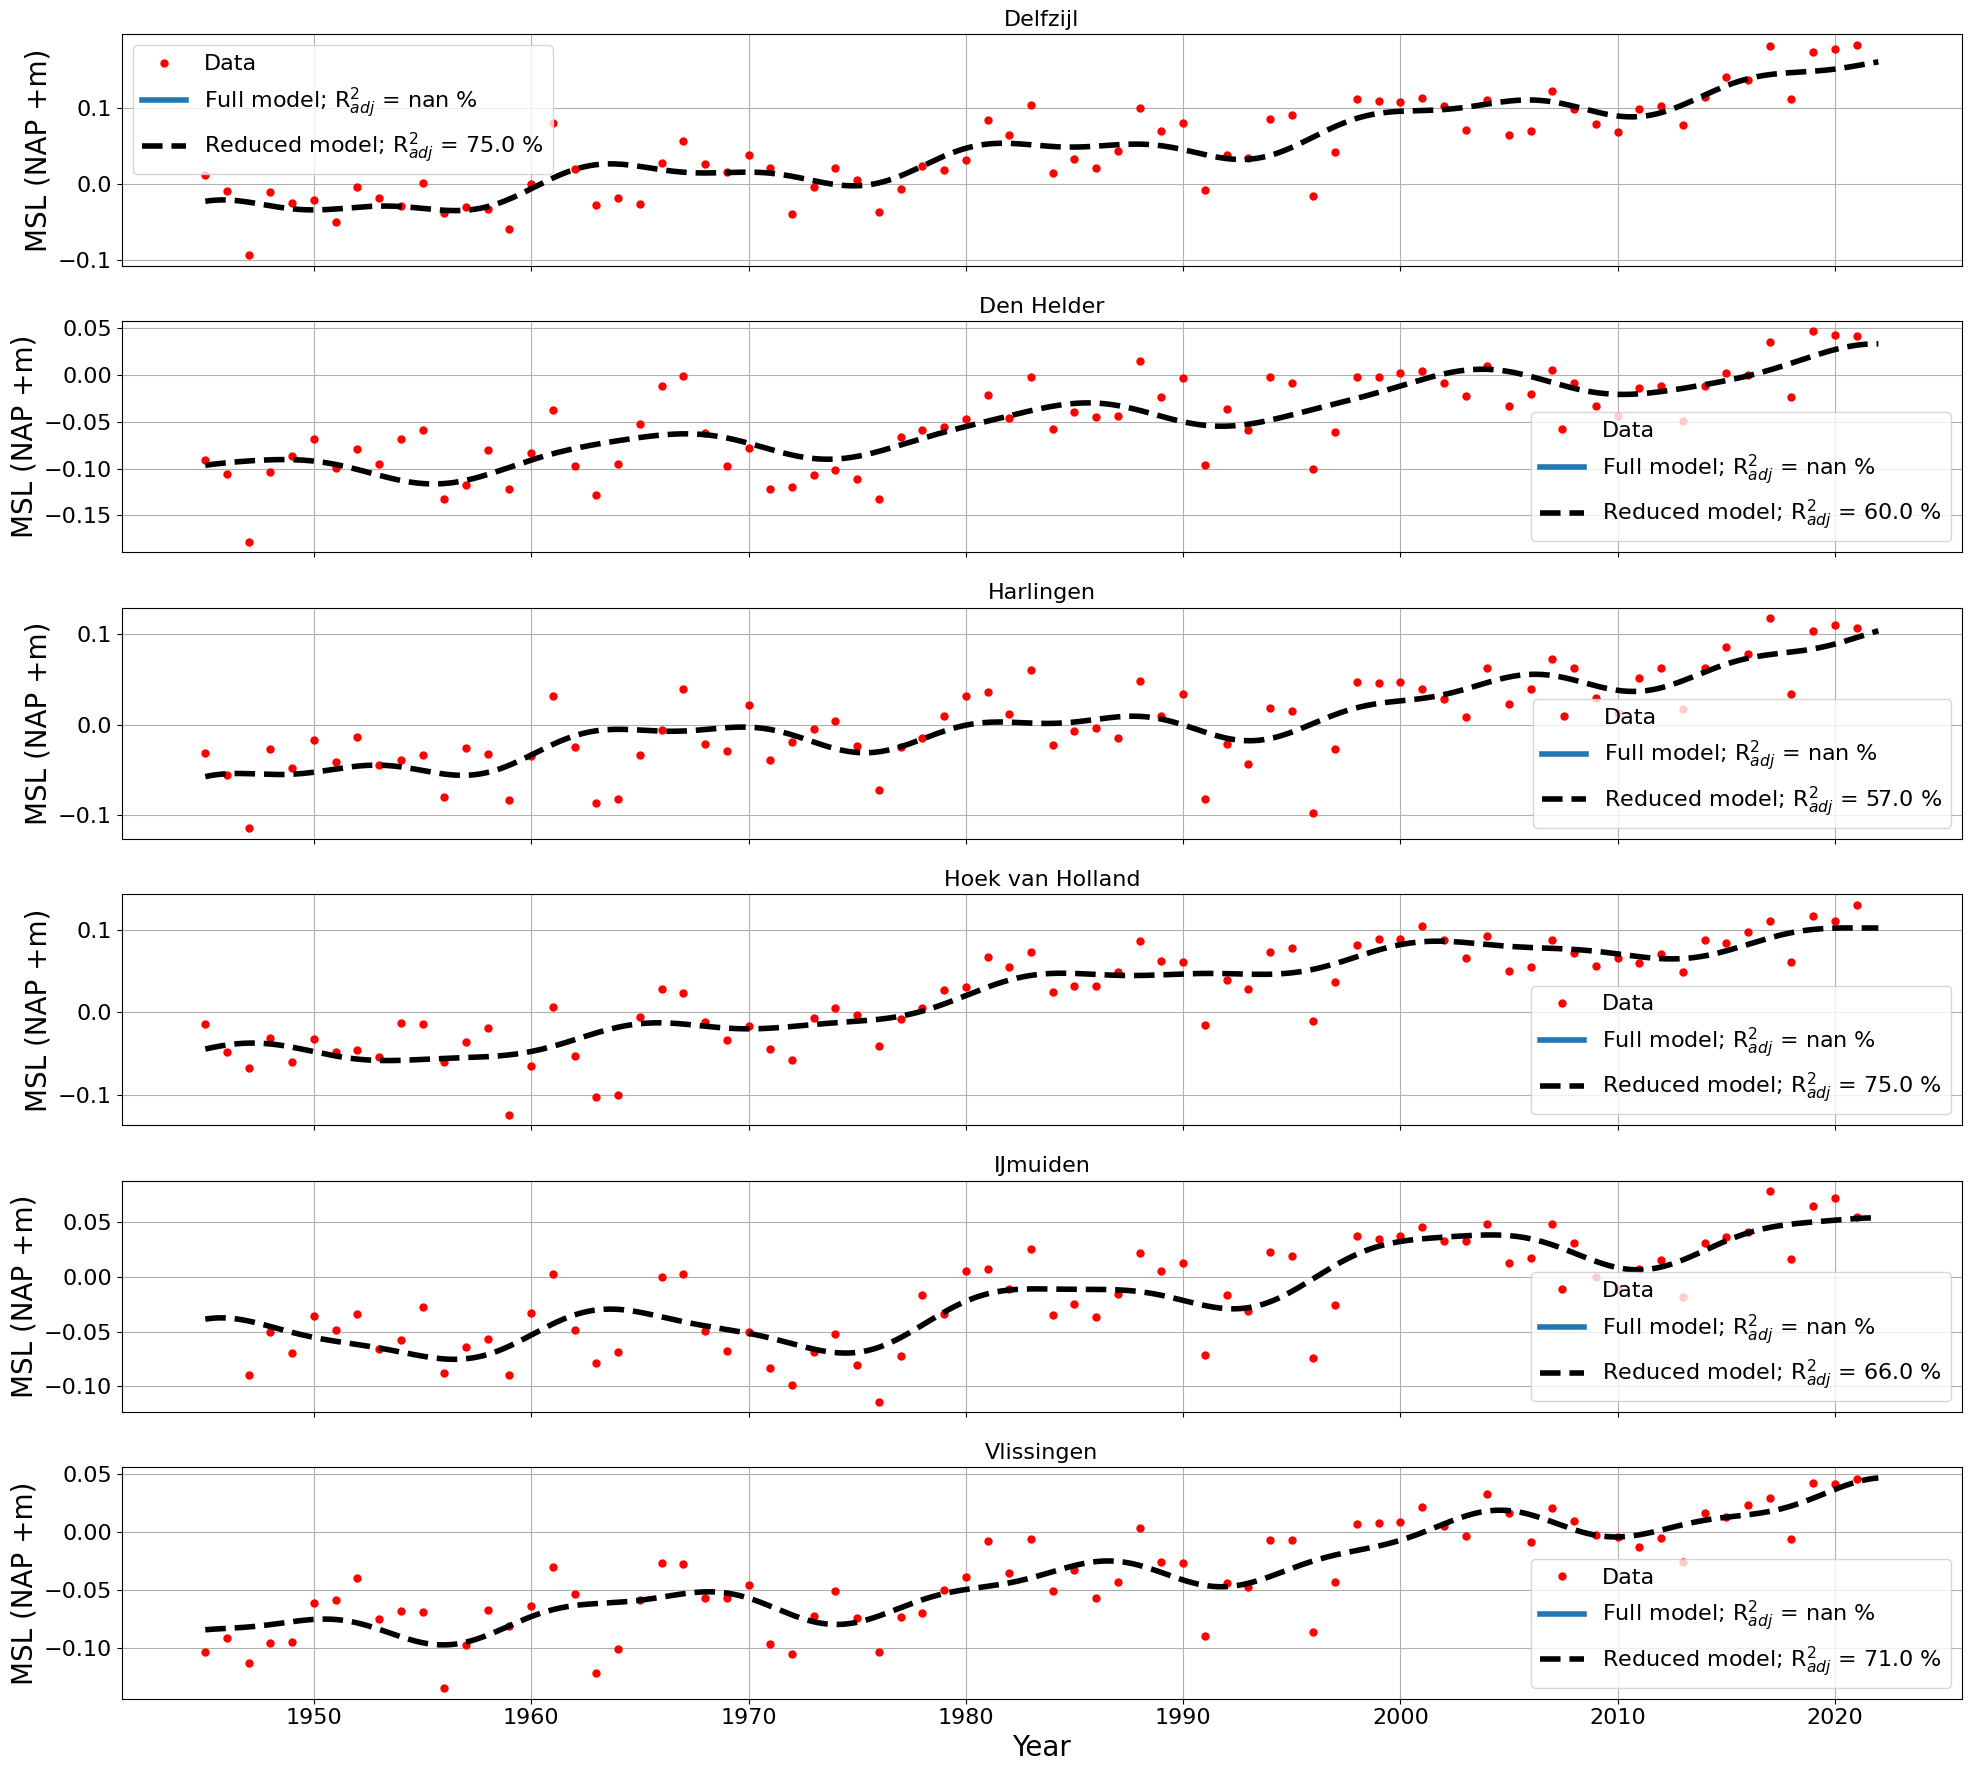

In [ ]:
xgr = np.linspace(1945, 2022, 1000)

fig, ax = plt.subplots(nrows = 6, ncols = 1, sharex = True, sharey = False, figsize = figsize)

for i, nm in enumerate(df['naam'].unique()):
    data = df[df['naam'] == nm]

    plt.subplot(6,1,i+1)
    
    stplot.plot_data(
        data['year'], data['z0'], 'r.', label = 'Data',
        markersize = 10)
    
    stplot.plot_model(
        mdl.fullModel, data['year'], data['z0'], xgr,
        modelname = 'Full model', 
        bounds = (
            bnd_lo + [tprescr_lo - data['year'].mean()],
            bnd_up + [tprescr_up - data['year'].mean()]))
    
    stplot.plot_model(
        mdl.reducedModel, data['year'], data['z0'], xgr, fmt = 'k--',
        modelname = 'Reduced model')
    
    plt.title(nm)
    plt.ylabel('MSL (NAP +m)')

    plt.legend()

plt.xlabel('Year')
plt.tight_layout()
plt.savefig(f'{PICTURES}/z0_model6.jpg')
    

#### F-test of significance of climate signal

In [ ]:
def Ftests_models(t, h):
    """
    Because of the bounds required to fit the full model, our normal procedures are not workable
    """
    ymodelRed, kRed = sup.generate_model_data(mdl.reducedModel, t, h)
    ymodelFull, kFull = sup.generate_model_data(
        mdl.fullModel, t, h,
        method = 'Bence',
        bounds = (
            bnd_lo + [tprescr_lo - t.mean()],
            bnd_up + [tprescr_up - t.mean()])
            )

    res = gof.Ftest_red(ydata = h, ymodel_full = ymodelFull, ymodel_red = ymodelRed, kfull = kFull, kred = kRed)
    return pd.DataFrame(res, index = [0])


In [ ]:
Fresult = df.groupby('naam').apply(
    lambda x: Ftests_models(x['year'], x['z0'])
)

c:\Users\Hessel Voortman\AppData\Local\Programs\Python\Python311\Lib\site-packages\hvec_stat\goodness_of_fit.py:145: RuntimeWarning: divide by zero encountered in scalar divide
  return counter / denom
c:\Users\Hessel Voortman\AppData\Local\Programs\Python\Python311\Lib\site-packages\hvec_stat\goodness_of_fit.py:145: RuntimeWarning: divide by zero encountered in scalar divide
  return counter / denom
c:\Users\Hessel Voortman\AppData\Local\Programs\Python\Python311\Lib\site-packages\hvec_stat\goodness_of_fit.py:145: RuntimeWarning: divide by zero encountered in scalar divide
  return counter / denom
c:\Users\Hessel Voortman\AppData\Local\Programs\Python\Python311\Lib\site-packages\hvec_stat\goodness_of_fit.py:145: RuntimeWarning: divide by zero encountered in scalar divide
  return counter / denom
c:\Users\Hessel Voortman\AppData\Local\Programs\Python\Python311\Lib\site-packages\hvec_stat\goodness_of_fit.py:145: RuntimeWarning: divide by zero encountered in scalar divide
  return counte

In [ ]:
Fresult.reset_index(inplace = True)
Fresult.drop(columns = 'level_1', inplace = True)

In [ ]:
Fresult

,naam,F,p,alpha,Falpha,Reject_H0
0,Delfzijl,inf,0.0,0.05,2.745915,True
1,Den Helder,inf,0.0,0.05,2.745915,True
2,Harlingen,inf,0.0,0.05,2.745915,True
3,Hoek van Holland,inf,0.0,0.05,2.745915,True
4,IJmuiden,inf,0.0,0.05,2.752970,True
5,Vlissingen,inf,0.0,0.05,2.745915,True


#### Comparison to IPCC

#### z-test for the difference of the means

In [ ]:
ipcc

,name,scenario,year,median,sigma,90%_band
0,Delfzijl,ssp119,2020,0.40,0.0,0.66
50,Delfzijl,ssp119,2120,0.42,0.0,0.55
49,Delfzijl,ssp585,2110,1.14,1.0,1.06
48,Delfzijl,ssp370,2110,0.98,1.0,0.86
47,Delfzijl,ssp245,2110,0.73,0.0,0.72
...,...,...,...,...,...,...
370,Vlissingen,ssp119,2060,0.45,0.0,0.48
369,Vlissingen,ssp585,2050,0.74,0.0,0.63
368,Vlissingen,ssp370,2050,0.66,0.0,0.54
374,Vlissingen,ssp585,2060,0.80,0.0,0.69


In [ ]:
ipcc = cp.copy(ipcc[['name', 'scenario', 'year', 'median', 'sigma']])
ipcc.rename(columns = {
    'median': 'mean_ipcc',
    'sigma': 'sigma_ipcc'
}, inplace = True)

ipcc

,name,scenario,year,mean_ipcc,sigma_ipcc
0,Delfzijl,ssp119,2020,0.40,0.0
50,Delfzijl,ssp119,2120,0.42,0.0
49,Delfzijl,ssp585,2110,1.14,1.0
48,Delfzijl,ssp370,2110,0.98,1.0
47,Delfzijl,ssp245,2110,0.73,0.0
...,...,...,...,...,...
370,Vlissingen,ssp119,2060,0.45,0.0
369,Vlissingen,ssp585,2050,0.74,0.0
368,Vlissingen,ssp370,2050,0.66,0.0
374,Vlissingen,ssp585,2060,0.80,0.0


In [ ]:
param = param.loc[param['model'] == 'Reduced', ['name', 'slope', 'sigma_slope']]
param.rename(columns = {
    'slope': 'mean_obs',
    'sigma_slope': 'sigma_obs'
}, inplace = True)
param['name'] = param['name'].str.title()
param

,name,mean_obs,sigma_obs
0,Delfzijl,242.0,17.0
1,Den Helder,164.0,17.0
2,Harlingen,185.0,18.0
3,Hoek Van Holland,217.0,16.0
4,Ijmuiden,147.0,16.0
5,Vlissingen,161.0,13.0


In [ ]:
all = ipcc.merge(param)
all

,name,scenario,year,mean_ipcc,sigma_ipcc,mean_obs,sigma_obs
0,Delfzijl,ssp119,2020,0.40,0.0,242.0,17.0
1,Delfzijl,ssp119,2120,0.42,0.0,242.0,17.0
2,Delfzijl,ssp585,2110,1.14,1.0,242.0,17.0
3,Delfzijl,ssp370,2110,0.98,1.0,242.0,17.0
4,Delfzijl,ssp245,2110,0.73,0.0,242.0,17.0
...,...,...,...,...,...,...,...
415,Vlissingen,ssp119,2060,0.45,0.0,161.0,13.0
416,Vlissingen,ssp585,2050,0.74,0.0,161.0,13.0
417,Vlissingen,ssp370,2050,0.66,0.0,161.0,13.0
418,Vlissingen,ssp585,2060,0.80,0.0,161.0,13.0


In [ ]:
res = all.groupby(by = ['year', 'name', 'scenario']).apply(
    lambda x: pd.DataFrame(sttests.Ztest_twosided(
        [x['mean_ipcc'], x['mean_obs']],
        [x['sigma_ipcc'], x['sigma_obs']], alpha = 0.05)
))
res

z    p  alpha         k  Reject H0?
year name       scenario                                               
2020 Delfzijl   ssp119   0  14.211765  1.0   0.05  1.959964        True
                ssp126   0  14.209412  1.0   0.05  1.959964        True
                ssp245   0  14.207059  1.0   0.05  1.959964        True
                ssp370   0  14.207059  1.0   0.05  1.959964        True
                ssp585   0  14.205882  1.0   0.05  1.959964        True
...                               ...  ...    ...       ...         ...
2150 Vlissingen ssp119   0  12.356923  1.0   0.05  1.959964        True
                ssp126   0  12.356154  1.0   0.05  1.959964        True
                ssp245   0  12.333846  1.0   0.05  1.959964        True
                ssp370   0  12.278343  1.0   0.05  1.959964        True
                ssp585   0  12.271440  1.0   0.05  1.959964        True

[420 rows x 5 columns]

#### End script
Prepared by HVEC lab, 2022